---
## Assignment 1.5: Regression and Correlation

Which of your Personal Focus Crimes share the most similar weekly rhythm — and which are completely out of sync?

*Draws from*: Week 4, Exercises 3.1, 3.2, and 3.3.

Select **at least 4** of your Personal Focus Crimes for this exercise. More is fine - if you want to be closer to the actual weekly exercise.

> * For each selected crime type, compute the total number of incidents for each of the **168 hours of the week** (i.e., Monday 00:00–01:00, Monday 01:00–02:00, ..., Sunday 23:00–00:00). Each crime type will give you a vector of 168 values.
>
> * **Scatterplot matrix**: Create a grid of pairwise scatterplots — one panel per pair of crime types, with one crime on each axis and each of the 168 hours as a point. Label each panel clearly with the two crime types being compared.
>
> * **Linear regression**: Using the closed-form equations from Week 4 (not a library), fit a regression line $y = ax + b$ to each pair and add it to the relevant panel:
>   $$a = \frac{\sum_i x_i y_i - N\langle x\rangle\langle y\rangle}{\sum_i x_i^2 - N\langle x\rangle^2}, \qquad b = \langle y \rangle - a\langle x \rangle$$
>
> * **$R^2$**: Compute $R^2$ for each pair and display the value on each panel. 
>
> * Looking at your results: which pair of crimes is **most correlated**? Which is **least correlated**? Does the answer match your intuition? Why might two crime types share a weekly rhythm — or not?

In [1]:
import pandas as pd
df = pd.read_csv('merged_sfpd.csv')
df['incident_category'] = df['incident_category'].replace('Larceny Theft', 'LARCENY/THEFT')

In [ ]:
df[]

In [2]:

personal_focus = [
    'LARCENY/THEFT',
    'NON-CRIMINAL',
    'ASSAULT',
    'VEHICLE THEFT',
    'DRUG/NARCOTIC',
    'VANDALISM',
    'WARRANTS',
    'BURGLARY',
    'SUSPICIOUS OCC'
]

df_pf = df[df['incident_category'].isin(personal_focus)].copy()
df_pf['incident_category'].value_counts()

incident_category
LARCENY/THEFT     772367
NON-CRIMINAL      179139
ASSAULT           167042
VEHICLE THEFT     126228
DRUG/NARCOTIC     117821
VANDALISM         114718
WARRANTS           99821
BURGLARY           91067
SUSPICIOUS OCC     79087
Name: count, dtype: int64

In [17]:
df_pf.head()

,data_loaded_at,incident_category,incident_date,incident_day_of_week,incident_time,incident_year,latitude,longitude,police_district
0,2025/06/20 12:17:56 PM,VEHICLE THEFT,2016-03-03,Thursday,19:30:00,2016,37.707968,-122.463545,TARAVAL
1,2025/06/20 12:17:56 PM,ASSAULT,2005-07-23,Saturday,16:40:00,2005,37.708311,-122.420084,INGLESIDE
2,2025/06/20 12:17:56 PM,ASSAULT,2006-09-25,Monday,22:15:00,2006,37.778486,-122.425839,NORTHERN
4,2025/06/20 12:17:56 PM,ASSAULT,2015-03-10,Tuesday,00:01:00,2015,37.775421,-122.403405,SOUTHERN
6,2025/06/20 12:17:56 PM,NON-CRIMINAL,2014-11-01,Saturday,13:00:00,2014,37.708031,-122.428737,INGLESIDE


In [25]:
df_hour = df_pf['incident_time'].str[0:2].astype(int)
df_pf['hour'] = df_hour
df_pf['day_of_week'] = df_pf['incident_day_of_week']

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_pf['day_of_week'] = pd.Categorical(df_pf['day_of_week'], categories=day_order, ordered=True)

hourly_counts = (
    df_pf.groupby(['incident_category', 'day_of_week', 'hour'])
    .size()
    .reset_index(name='count')
)

# Create a 168-hour index: day*24 + hour
hourly_counts['hour_of_week'] = hourly_counts['day_of_week'].cat.codes * 24 + hourly_counts['hour']

hourly_counts = (
    hourly_counts.pivot_table(index='hour_of_week', columns='incident_category', values='count', fill_value=0)
)

hourly_counts.columns.name = None
hourly_counts = hourly_counts.sort_index().reset_index(drop=True)

hourly_counts


/tmp/ipykernel_63065/969993522.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pf.groupby(['incident_category', 'day_of_week', 'hour'])


,ASSAULT,BURGLARY,DRUG/NARCOTIC,LARCENY/THEFT,NON-CRIMINAL,SUSPICIOUS OCC,VANDALISM,VEHICLE THEFT,WARRANTS
0,1842.0,512.0,442.0,6705.0,1562.0,748.0,1208.0,962.0,562.0
1,2217.0,351.0,290.0,4591.0,1029.0,469.0,962.0,608.0,411.0
2,2039.0,343.0,218.0,2905.0,826.0,435.0,934.0,541.0,311.0
3,902.0,386.0,136.0,1696.0,426.0,254.0,608.0,337.0,233.0
4,473.0,304.0,140.0,1046.0,253.0,196.0,339.0,230.0,165.0
...,...,...,...,...,...,...,...,...,...
163,1229.0,609.0,791.0,7131.0,1272.0,515.0,1092.0,1151.0,684.0
164,1289.0,561.0,581.0,6953.0,1178.0,477.0,1187.0,1315.0,537.0
165,1386.0,578.0,529.0,6271.0,1167.0,500.0,1256.0,1362.0,508.0
166,1423.0,547.0,729.0,6937.0,1432.0,481.0,1406.0,1565.0,636.0


/tmp/ipykernel_63065/2238384593.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.98])


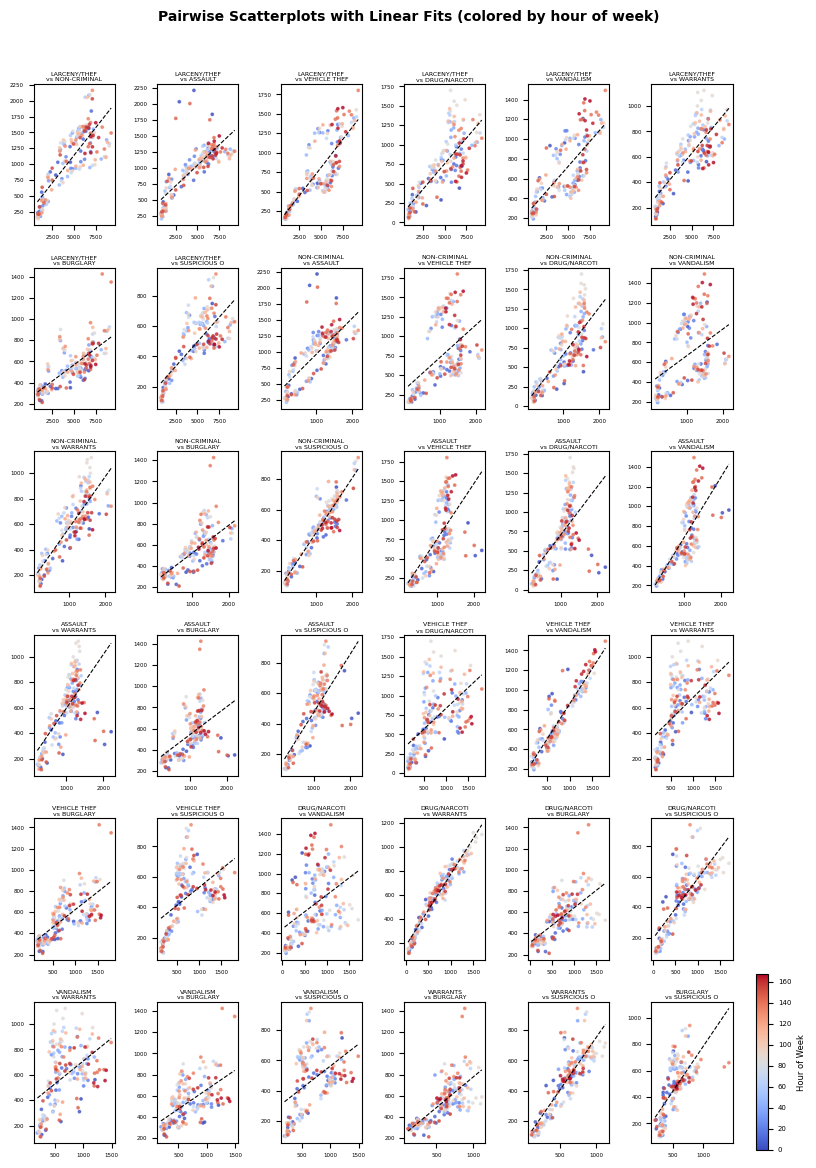

In [26]:
from itertools import combinations
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt

# Linear regression from scratch using Equations 1 and 2
def linear_regression(x, y):
    N = len(x)
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    a = (np.sum(x * y) - N * x_mean * y_mean) / (np.sum(x**2) - N * x_mean**2)
    b = y_mean - a * x_mean
    return a, b

# Hour-of-week color gradient
hours = np.arange(168)
norm = mcolors.Normalize(vmin=0, vmax=167)
cmap = cm.coolwarm
pairs = list(combinations(personal_focus, 2))

# Create 6x6 subplot grid (A4-ish size)
fig, axes_grid = plt.subplots(6, 6, figsize=(8.27, 11.69))

for idx, (c1, c2) in enumerate(pairs):
    row = idx // 6
    col = idx % 6
    ax = axes_grid[row, col]
    
    x = hourly_counts[c1].values.astype(float)
    y = hourly_counts[c2].values.astype(float)
    
    # Scatter with hour-of-week coloring
    ax.scatter(x, y, s=3, alpha=0.7, c=hours, cmap=cmap, norm=norm)
    
    # Linear regression
    a, b = linear_regression(x, y)
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = a * x_line + b
    ax.plot(x_line, y_line, color='black', linewidth=0.8, linestyle='--')
    
    # Shorten labels for readability
    label1 = c1[:12]
    label2 = c2[:12]
    ax.set_title(f"{label1}\nvs {label2}", fontsize=4.5, pad=2)
    ax.tick_params(axis='both', labelsize=4)

plt.subplots_adjust(hspace=0.7, wspace=0.4)
plt.suptitle("Pairwise Scatterplots with Linear Fits (colored by hour of week)", 
             fontsize=10, fontweight='bold', y=0.995)

# Add a small colorbar for the hour-of-week gradient
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.92, 0.02, 0.015, 0.15])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Hour of Week', fontsize=6)
cbar.ax.tick_params(labelsize=5)

plt.tight_layout(rect=[0, 0, 0.91, 0.98])
plt.show()

Most similar pair:    DRUG/NARCOTIC & WARRANTS  (R² = 0.9359)
Most dissimilar pair: DRUG/NARCOTIC & VANDALISM  (R² = 0.1848)

All R² values (sorted):
  DRUG/NARCOTIC             vs WARRANTS                   R² = 0.9359
  NON-CRIMINAL              vs SUSPICIOUS OCC             R² = 0.8756
  VEHICLE THEFT             vs VANDALISM                  R² = 0.8686
  WARRANTS                  vs SUSPICIOUS OCC             R² = 0.7299
  NON-CRIMINAL              vs WARRANTS                   R² = 0.7256
  LARCENY/THEFT             vs VEHICLE THEFT              R² = 0.6884
  LARCENY/THEFT             vs NON-CRIMINAL               R² = 0.6736
  LARCENY/THEFT             vs WARRANTS                   R² = 0.6699
  LARCENY/THEFT             vs DRUG/NARCOTIC              R² = 0.6414
  NON-CRIMINAL              vs DRUG/NARCOTIC              R² = 0.6267
  DRUG/NARCOTIC             vs SUSPICIOUS OCC             R² = 0.6160
  LARCENY/THEFT             vs ASSAULT                    R² = 0.6158
  LARCENY/

/tmp/ipykernel_63065/3114593690.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.98])


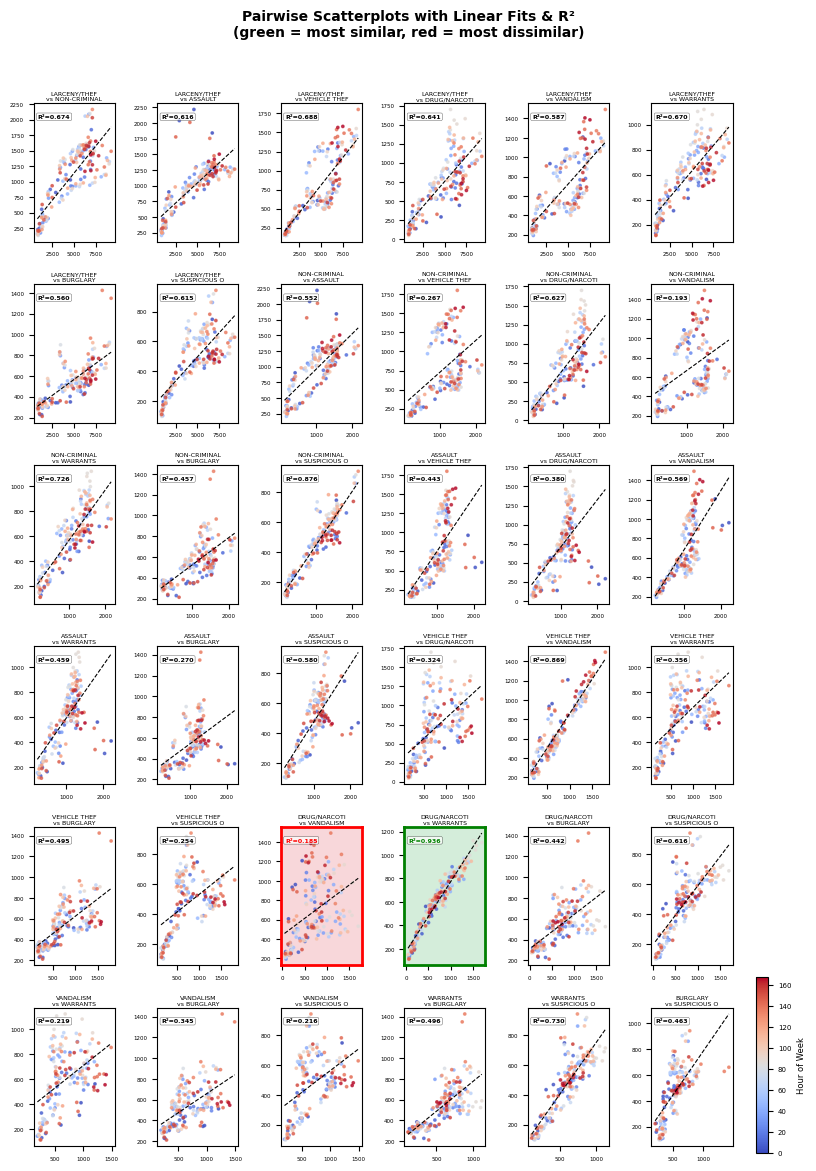

In [27]:
# R^2 function
def r_squared(x, y):
    a, b = linear_regression(x, y)
    y_pred = a * x + b
    ss_res = np.sum((y - y_pred) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    if ss_tot == 0:
        return 0.0
    return 1 - ss_res / ss_tot

# Calculate R^2 for all pairs
r2_values = {}
for c1, c2 in pairs:
    x = hourly_counts[c1].values.astype(float)
    y = hourly_counts[c2].values.astype(float)
    r2_values[(c1, c2)] = r_squared(x, y)

# Find most similar and most dissimilar pairs
most_similar = max(r2_values, key=r2_values.get)
most_dissimilar = min(r2_values, key=r2_values.get)

print(f"Most similar pair:    {most_similar[0]} & {most_similar[1]}  (R² = {r2_values[most_similar]:.4f})")
print(f"Most dissimilar pair: {most_dissimilar[0]} & {most_dissimilar[1]}  (R² = {r2_values[most_dissimilar]:.4f})")
print()

# Print all R² values sorted
print("All R² values (sorted):")
for pair, r2 in sorted(r2_values.items(), key=lambda x: x[1], reverse=True):
    print(f"  {pair[0]:25s} vs {pair[1]:25s}  R² = {r2:.4f}")

# --- Mega-plot with R² and highlights ---
fig, axes_grid = plt.subplots(6, 6, figsize=(8.27, 11.69))

for idx, (c1, c2) in enumerate(pairs):
    row = idx // 6
    col = idx % 6
    ax = axes_grid[row, col]
    
    x = hourly_counts[c1].values.astype(float)
    y = hourly_counts[c2].values.astype(float)
    
    # Highlight most similar (green) and most dissimilar (red)
    is_similar = (c1, c2) == most_similar
    is_dissimilar = (c1, c2) == most_dissimilar
    
    if is_similar:
        ax.set_facecolor('#d4edda')
        for spine in ax.spines.values():
            spine.set_edgecolor('green')
            spine.set_linewidth(2)
    elif is_dissimilar:
        ax.set_facecolor('#f8d7da')
        for spine in ax.spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(2)
    
    # Scatter with hour-of-week coloring
    ax.scatter(x, y, s=3, alpha=0.7, c=hours, cmap=cmap, norm=norm)
    
    # Linear regression line
    a, b = linear_regression(x, y)
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = a * x_line + b
    ax.plot(x_line, y_line, color='black', linewidth=0.8, linestyle='--')
    
    # R² text
    r2 = r2_values[(c1, c2)]
    ax.text(0.05, 0.92, f"R²={r2:.3f}", transform=ax.transAxes, fontsize=4.5,
            verticalalignment='top', fontweight='bold',
            color='green' if is_similar else ('red' if is_dissimilar else 'black'),
            bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, linewidth=0.3))
    
    label1 = c1[:12]
    label2 = c2[:12]
    ax.set_title(f"{label1}\nvs {label2}", fontsize=4.5, pad=2)
    ax.tick_params(axis='both', labelsize=4)

plt.subplots_adjust(hspace=0.7, wspace=0.4)
plt.suptitle("Pairwise Scatterplots with Linear Fits & R²\n(green = most similar, red = most dissimilar)", 
             fontsize=10, fontweight='bold', y=0.998)

# Colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar_ax = fig.add_axes([0.92, 0.02, 0.015, 0.15])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Hour of Week', fontsize=6)
cbar.ax.tick_params(labelsize=5)

plt.tight_layout(rect=[0, 0, 0.91, 0.98])
plt.show()